# Using Transformed Variables in Regression Models

The phrase "feature engineering" refers to methods of transforming the feature variables for a model in order to improve model performance. This lesson discusses feature engineering in the context of linear regression, but the techniques it demonstrates are more broadly applicable.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Load mammals data set
mammals_path = Path('..', 'assets', 'data', 'mammals.txt')
cols = ['brain', 'body']
mammals = pd.read_csv(mammals_path, sep='\t', names=cols, header=0)

**Exercise (10 mins.)**

- Drop mammals with body weight above 200 kg.

In [3]:
# /scrub/
mammals = mammals.loc[mammals.loc[:, 'body'] < 200, :].sort_values('body')
mammals.head()

,brain,body
13,0.005,0.14
39,0.010,0.25
19,0.023,0.30
54,0.048,0.33
38,0.023,0.40


- Create a linear regression model of brain weight against body weight: $\mbox{brain} = \beta_0 + \beta_1 * \mbox{body}$

In [4]:
# /scrub/
from sklearn.linear_model import LinearRegression

In [5]:
# /scrub/
linreg = LinearRegression()

In [6]:
# /scrub/
feature_cols = ['body']

X = mammals.loc[:, feature_cols]
y = mammals.loc[:, 'brain']

linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

- Superimpose a line plot of the fitted values from that model on a scatterplot of the individual data points.

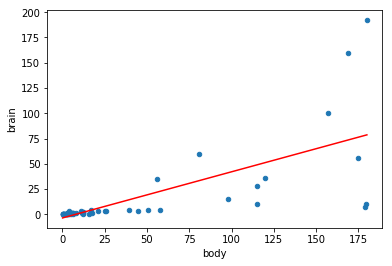

In [7]:
# /scrub/
y_fit = linreg.predict(X)
ax = mammals.plot(kind='scatter', x='body', y='brain')
ax.plot(X, y_fit, c='r');

$\blacksquare$

Linear regression creates a model that is linear in terms of features that you pass into it. **But linear regression can capture non-linear relationships with your original features if you give it non-linear transformations of those features.**

For instance, the code below fits this model:

$\mbox{brain} = \beta_0 + \beta_1 * \mbox{body} + beta_2 * \mbox{body}^2$

In [8]:
# Re-run the regression with an additional squared term
# /scrub/
mammals.loc[:, 'body_squared'] = mammals.loc[:, 'body']**2
feature_cols = ['body', 'body_squared']

X = mammals.loc[:, feature_cols]
y = mammals.loc[:, 'brain']

linreg = LinearRegression()
linreg.fit(X, y)
y_fit = linreg.predict(X)

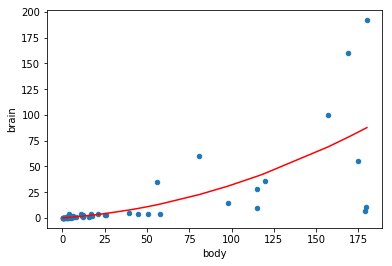

In [9]:
# Plot the resulting model on top of the corresponding scatterplot
# /scrub/
ax = mammals.plot(kind='scatter', x='body', y='brain')
ax.plot(mammals.loc[:, 'body'], y_fit, c='r');

### Polynomial Terms

A polynomial function of x has the form $c_0 + c_1x + c_2x^2 + c_3x^3 + \ldots$.

If you give a linear regression model $x$, $x^2$, and $x^3$ as features, for instance, it will find the $\beta_0$, $\beta_1$, $\beta_2$, and $\beta_3$ that minimizes mean-squared error for using $\beta_0 + \beta_1x + \beta_2x^2 + \beta_3x^3$ to predict $y$.

It can always recover simple linear regression by setting the coefficients on the higher-order terms to 0, so adding these higher-order terms only increases the set of relationships that the model can capture.

**Exercise (1 min., post answers right away.)**

- How does adding higher-order polynomial terms as inputs to a linear regression model affect its bias and variance?

/scrub/

Decreases (or at least does not increase) bias, increases variance.

$\blacksquare$

**Every additional polynomial term gives your model an additional chance to change directions.**

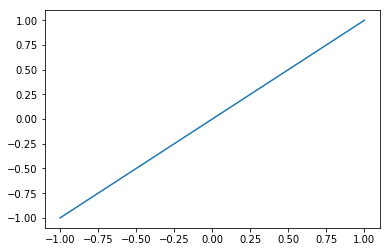

In [10]:
# first-order
x = np.linspace(-1, 1, 100)
plt.plot(x, x);

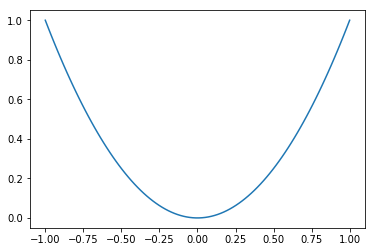

In [11]:
# second-order
plt.plot(x, x**2);

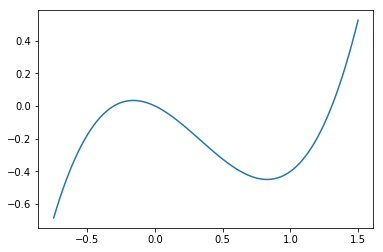

In [12]:
# third-order
x = np.linspace(-.75, 1.5, 100)
plt.plot(x, -.4*x - x**2 + x**3);

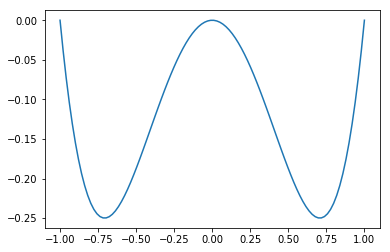

In [13]:
# fourth-order
x = np.linspace(-1, 1, 100)
plt.plot(x, -x**2 + x**4);

Too many polynomial terms leads to overfitting

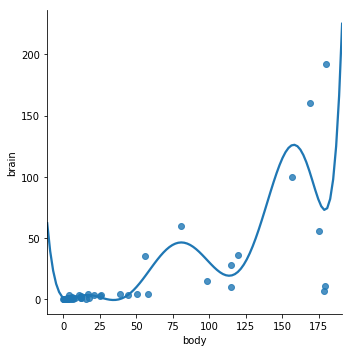

In [14]:
# 8th-order model
g = sns.lmplot(x='body', y='brain', data=mammals, ci=None, order=8);

An (n-1)-order polynomial can always fit n data points perfectly. It is definitely overfitting!

/Users/gGandenberger/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/regression.py:237: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)


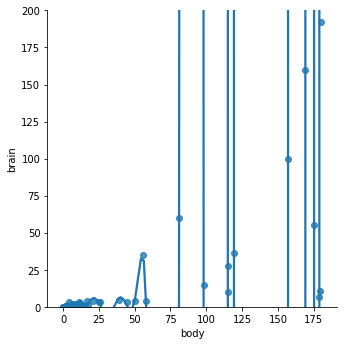

In [15]:
# 50th-order model
fig = sns.lmplot(x='body', y='brain', data=mammals, ci=None, order=50);
ax = fig.axes
ax[0,0].set_ylim(0, 200);

Including multiple transformations of one variable complicates coefficient interpretation.

In [16]:
# Print intercept and coefficients from second-order model we created earlier
# /scrub/
print(linreg.intercept_)
print(linreg.coef_)

0.13198730573592954
[0.10843153 0.00210168]


**Exercise (2 mins., post answers right away)**

- Write down the equation of this second-order model (with fitted coefficient values).

/scrub/

$brain = .132 + .108*body + .0021 * body^2$

- How would you normally interpret the coefficient on `body` in a linear regression model of brain weight against body weight? Why doesn't that interpretation work in this case?

/scrub/

You would normally interpret the coefficient on a variable in a linear regression model as telling you how your model's predictions change with a one-unit increase in that variable, holding all other variables fixed. That interpretation doesn't work here because you can't have a one-unit increase in `body` while holding `body^2` fixed.

$\blacksquare$

**sklearn has a "transformer" that generates polynomial terms**

In [17]:
# sklearn transformers have the same interface as "estimators" (models)
# except that you fit them on features and use them to transform features,
# rather than fitting them on features and a target and using them to predict
# target values.
# /scrub/
from sklearn.preprocessing import PolynomialFeatures

X = mammals.loc[:, ['body']]
pf = PolynomialFeatures(degree=3, include_bias=False)
pf.fit(X)
X_poly = pf.transform(X)  # returns new array without modifying X

A transformer returns a modified copy of the object it acts on without changing that objects in place.

**Exercise (10 mins., pair programming)**

Use the Boston housing data for the exercises below.

In [18]:
from sklearn.datasets import load_boston

boston = load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = pd.DataFrame(boston.target, columns=['MEDV'])
boston = pd.concat([X, y], axis=1)
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


- Create a linear regression model for MEDV against DIS with no higher-order polynomial terms.

In [19]:
# /scrub/
feature_cols = ['DIS']
X = boston.loc[:, feature_cols]
y = boston.loc[:, 'MEDV']

lr_boston1 = LinearRegression()
lr_boston1.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

- Create a linear regression model for MEDV against DIS with polynomial terms for DIS up to and including degree seven.

In [20]:
# /scrub/
pf = PolynomialFeatures(degree=7, include_bias=False)
pf.fit(X)
X7 = pf.transform(X)

lr_boston7 = LinearRegression()
lr_boston7.fit(X7, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

- **Bonus:** Create line plots of your models' fitted values as a function of DIS and overlay them on scatterplots of MEDV against DIS.

*Tip:* You need to plot your model's predictions against DIS only. If the result looks like spaghetti, then you probably need to sort on DIS. Either sort the DataFrame on DIS from the beginning, or use the `.argsort()` method to get the sequence of row numbers that would sort it on DIS, and use that sequence to select rows for both x and y.

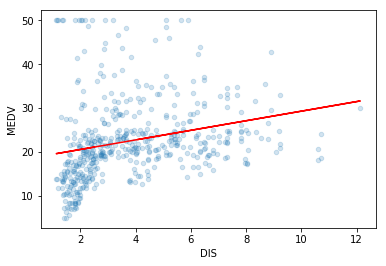

In [21]:
# /scrub/

y_pred_boston1 = lr_boston1.predict(X)

ax = boston.plot(kind='scatter', x='DIS', y='MEDV', alpha=.2)
ax.plot(X, y_pred_boston1, c='r');

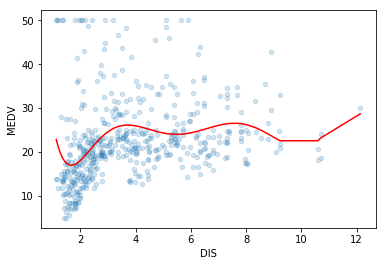

In [22]:
# /scrub/

y_pred_boston7 = lr_boston7.predict(X7)

dis_order = boston.loc[:, 'DIS'].argsort()

ax = boston.plot(kind='scatter', x='DIS', y='MEDV', alpha=.2)
ax.plot(boston.loc[dis_order, 'DIS'], y_pred_boston7[dis_order], c='r');

- **Bonus:** Create a model with $DIS$ and $DIS^{-1}$ as features and plot its predictions overlayed on a scatterplot of MEDV against DIS.

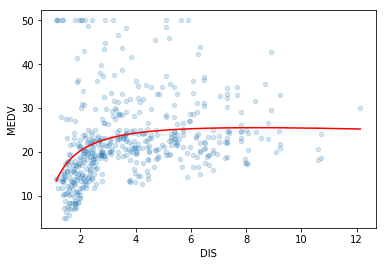

In [23]:
# /scrub/

boston.loc[:, '1/DIS'] = 1/boston.loc[:, 'DIS']
feature_cols = ['DIS', '1/DIS']

X_neg = boston.loc[:, feature_cols]

lr_boston_neg = LinearRegression()
lr_boston_neg.fit(X_neg, y)
y_pred_boston_neg = lr_boston_neg.predict(X_neg)

ax = boston.plot(kind='scatter', x='DIS', y='MEDV', alpha=.2)
ax.plot(boston.loc[dis_order, 'DIS'], y_pred_boston_neg[dis_order], c='r');

$\blacksquare$

**Notes.**

- In statistics, it is extremely unusual to use more than a third-order polynomial. It is more common in machine learning, where the emphasis tends to be on predictive accuracy rather than understanding.
- It would be unusual to use a polynomial term without including all lower-order polynomial terms.
- In addition to polynomial terms (with positive integer exponents), it can also be beneficial to include terms with negative exponents (e.g. $x^{-1}=1/x$) and/or fractional exponents (e.g. $x^{1/2}=\sqrt{X}$).

Let's use 5-fold cross-validation to choose the polynomial order between 1 and 10 that gives the best results in terms of MSE on held-out data, taking advantage of the scikit-learn convenience function `cross_val_score`.

In [24]:
# /scrub/
from sklearn.model_selection import cross_val_score, KFold

kf = KFold(n_splits=5, shuffle=True)

for poly_degree in range(1, 11):
    pf = PolynomialFeatures(degree=poly_degree, include_bias=False)
    X_poly = pf.fit_transform(X)
    lr = LinearRegression()
    score = np.mean(-cross_val_score(lr, X_poly, y, cv=kf, scoring='neg_mean_squared_error'))
    print(poly_degree, score)

1 79.69264860955192
2 77.98349730520968
3 78.81924976719183
4 76.75410587580484
5 83.30243653514376
6 82.4284051682283
7 605.0556718090454
8 1179.370024648321
9 82.74455591320267
10 1465.1197958533094


**Exercise (4 mins.)** 

- Create a model with $DIS$ and $DIS^{-1}$ as features and score it using 5-fold cross-validation.

In [25]:
# /scrub/
kf = KFold(n_splits=5, shuffle=True)

X_poly = pd.DataFrame(boston.loc[:, ['DIS']])
X_poly.loc[:, '1/DIS'] = X.loc[:, 'DIS']**(-1)
lr = LinearRegression()
np.mean(-cross_val_score(lr, X_poly, y, cv=kf, scoring='neg_mean_squared_error'))

77.89476902216134

$\blacksquare$

### Interaction Terms

Sometimes the significance of one feature depends on the value of another feature.

For instance, perhaps median housing prices increase as you get closer to a major employment center *unless crime is high around that area*.

We can model these kinds of "interaction effects" by including the *products* of the interacting variables as features in our models.

For example:

$$MEDV = \beta_0 + \beta_1 * DIS + \beta_2 * CRIM + \beta_{12} (DIS * CRIM)$$

In [26]:
# Implement the model above
# /scrub/
feature_cols = ['DIS', 'CRIM']
X = boston.loc[:, feature_cols]
X.loc[:, 'INTERACTION'] = X.loc[:, 'DIS'] * X.loc[:, 'CRIM']
y = boston.loc[:, 'MEDV']

lr_interaction = LinearRegression()
lr_interaction.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [27]:
# /scrub/
print(lr_interaction.intercept_)
print(lr_interaction.coef_)

22.688993984140442
[ 0.47072015  0.47554791 -0.53442481]


**Exercise (2 mins., post answers right away.)**

- Write down the fitted model we just created.

/scrub/

$$MEDV = 22.62 + 0.48 * DIS + 0.467 * CRIM - 0.527 (DIS * CRIM)$$

$\blacksquare$

In [28]:
# check descriptive stats
# /scrub/
X.loc[:, ['DIS', 'CRIM']].describe()

,DIS,CRIM
count,506.000000,506.000000
mean,3.795043,3.613524
std,2.105710,8.601545
min,1.129600,0.006320
25%,2.100175,0.082045
50%,3.207450,0.256510
75%,5.188425,3.677083
max,12.126500,88.976200


**Recall the usual interpretation of the coefficient on DIS:** how much the model's prediction for MEDV changes with a one-unit increase in DIS, all else being equal (i.e. for a particular value of CRIM).

**With interaction terms, interpreting the coefficients for a feature DIS requires specifying particular values for the interacting variables.**

For instance, if CRIM is fixed at its 25th percentile value of 0.082, we get

$MEDV = 22.62 + 0.48 * DIS + 0.467 * CRIM - 0.527 (DIS * CRIM)$

$MEDV = 22.62 + 0.48 * DIS + 0.467 * 0.082 - 0.527 (DIS * 0.082)$

$MEDV = 22.62 + 0.48 * DIS + 0.038 - 0.043 * DIS$

$MEDV = 22.658 + 0.437 * DIS$

So **at CRIM=.082**, the model's prediction for MEDV increases by .437 when DIS increases by one. It's better on average to be away from employment centers when crime is low.

The story is different when CRIM has its 75th percentile value of 3.64:

$MEDV = 22.62 + 0.48 * DIS + 0.467 * CRIM - 0.527 (DIS * CRIM)$

$MEDV = 22.62 + 0.48 * DIS + 0.467 * 3.64 - 0.527 (DIS * 3.64)$

$MEDV = 22.62 + 0.48 * DIS + 1.70 - 1.92 * DIS$

$MEDV = 24.32 -1.44 * DIS$

**At CRIM=3.64**, the model's prediction for MEDV *decreases* by 1.44 when DIS increases by one. It's better on average to be close to employment centers when crime is high.

**Exercise (8 mins., pair programming)**

- How does adding interaction terms affect a model's bias and variance?

/scrub/

Decreases (or at least does not increase) bias, increases variance.

- Using 5-fold cross-validation, calculate the MSE for a model predicting MEDV from DIS and CRIM without an interaction term. *Hint*: use sklearn.model_selection.cross_val_score

In [29]:
# /scrub/
feature_cols = ['DIS', 'CRIM']
X = boston.loc[:, feature_cols]
y = boston.loc[:, 'MEDV']
lr = LinearRegression()
kf = KFold(n_splits=5, shuffle=True)

np.mean(-cross_val_score(lr, X, y, cv=kf, scoring='neg_mean_squared_error'))

71.5336629321398

- Using 5-fold cross-validation, calculate the MSE for a model predicting MEDV from DIS and CRIM with an interaction term. *Hint*: use sklearn.model_selection.cross_val_score

In [30]:
# /scrub/
feature_cols = ['DIS', 'CRIM']
X = boston.loc[:, feature_cols]
X.loc[:, 'INTERACTION'] = X.loc[:, 'DIS'] * X.loc[:, 'CRIM']
y = boston.loc[:, 'MEDV']
lr = LinearRegression()

np.mean(-cross_val_score(lr, X, y, cv=kf, scoring='neg_mean_squared_error'))

71.57997003260736

- **Bonus:** Find the best model you can, as measured by MSE in 5-fold cross-validation.

$\blacksquare$

### Log Transformations

When your data is very skewed, try a log transformation.

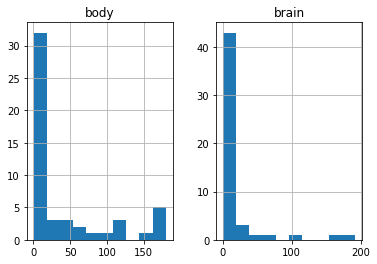

In [31]:
# Plot histograms of mammal brain and body sizes
# /scrub/
axes = mammals.loc[:, ['brain', 'body']].hist()

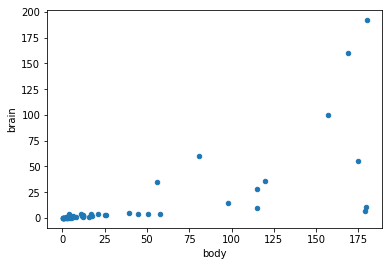

In [32]:
# Plot scatterplot of brain size against body size
# /scrub/
ax = mammals.plot(kind='scatter', x='body', y='brain')

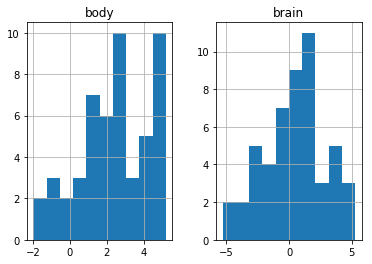

In [33]:
# Plot histograms of mammal brain and body sizes after a log transformation
# /scrub/
log_mammals = np.log(mammals.loc[:, ['brain', 'body']])
axes = log_mammals.hist()

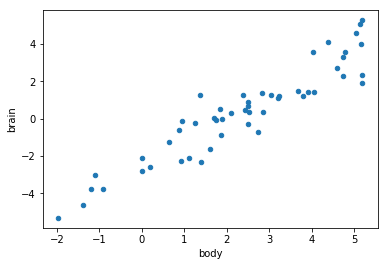

In [34]:
# Plot scatterplot of brain size against body size after log transformation
# /scrub/
ax = log_mammals.plot(kind='scatter', x='body', y='brain');

Because we applied a log transformation to $y$ as well as $x$, we need to be careful about how we interpret the MSE values.

In [35]:
# Train and score a linear model in the original space.
# This model isn't overfitting significantly, so let's not
# worry about a train/test split.
# /scrub/
from sklearn import metrics

X = mammals.loc[:, ['body']]
y = mammals.loc[:, 'brain']
lr_mammals = LinearRegression()
lr_mammals.fit(X, y)
y_pred = lr_mammals.predict(X)
metrics.mean_squared_error(y, y_pred)

712.8433296657507

In [36]:
# Train and score a linear model in the log-transformed space.
# This model isn't overfitting significantly, so let's not
# worry about a train/test split.
# /scrub/
log_mammals = np.log(mammals)
X_log = log_mammals.loc[:, ['body']]
y_log = log_mammals.loc[:, 'brain']

lr_log_mammals = LinearRegression()
lr_log_mammals.fit(X_log, y_log)
y_pred_log = lr_log_mammals.predict(X_log)
metrics.mean_squared_error(y_log, y_pred_log)

0.7312406573779776

Not a fair comparison! MSE for the second model is in log-space.

In [37]:
# Get MSE for the log-log model in the original space
# /scrub/
metrics.mean_squared_error(y, np.exp(y_pred_log))

918.872588599047

**What's going on?**

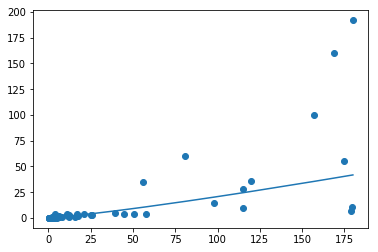

In [38]:
fix, ax = plt.subplots()
ax.scatter(X, y);
ax.plot(X, np.exp(y_pred_log));

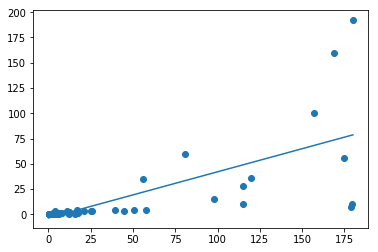

In [39]:
fix, ax = plt.subplots()
ax.scatter(X, y);
ax.plot(X, y_pred);

The model that we fit in log-log space is getting killed by the points in the top-right:

- MSE punishes large errors.
- Errors that are large in the original space don't look so large in log-log space, so the model doesn't focus on them as much as it "should."

**So which model should you use?** Probably the log-log model.

The original model is better if MSE of brain size prediction is **really** what you care about. But is being off by 1 kg when predicting elephant brain size really as bad as being off by 1 kg when predicting rabbit brain size? Maybe what we really care about is more like *percent error* in terms of number of kg -- that's what a model for the log of brain size optimizes for.

In addition, the log-log model conveys more understanding: modeling log of brain size as a linear function of log of body size plus random noise seems to capture what is really going on.

In [40]:
print('mean percent error of original model:', ((y-y_pred)/y).mean())
print('mean percent error of model fit in log-log space:',
      ((np.exp(y_log)-np.exp(y_pred_log)/np.exp(y))).mean()
     )

mean percent error of original model: 31.90019486524984
mean percent error of model fit in log-log space: 14.834354065896235


**Takeaways:**

- When your data is highly skewed, try a log transformation.
- When you evaluate a model that transforms $y$, make sure that you calculate metrics for different models on the same scale.
- Make sure that the metric you are optimizing reflects what you care about.

**Notes:**

- A log-transformed variable typically replaces the original variable in a regression analysis, unlike a polynomial term.
- You can apply a log transformation to any combination of your features and your target variable.

### Summary

- Linear regression *can* capture non-linear relationships *when you provide the appropriate non-linear transformations*.
- Every polynomial term you add allows your model to change directions once.
- Log transformations are appropriate for variables with highly skewed distributions.